# Estimator Representations

This script's purpose is to generate really clean estimator figures in a simple framework. We are only using curve fit with an initial value in the appropriate parameter space to estimate all pixels of the brain. The model used is the biexponential model with an offset term added. Normalization is not done beforehand but is done afterwards.

In [116]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os

In [117]:
brain_data = scipy.io.loadmat(os.getcwd() + '/MB_References/BLSA_1742_04_MCIAD_m41/NESMA_slice5.mat')
I_raw = brain_data['slice_oi']

n_vert, n_hori, n_elements = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements)*(t_increment_brain), n_elements)

#All pixels with a lower mask amplitude are considered to be free water (i.e. vesicles)
mask_amplitude = 740

#This is important for regularization if this is deemed necessary here
ob_weight = 100

MB_model = False

init_p = (0.2, 0.8, 20, 80, 1)
lb = [0,0,0,0,0]
ub = [np.inf,np.inf, 60, 300, np.inf]

vert1 = 165
vert2 = 180
hori1 = 120
hori2 = 180

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]

In [118]:
############# Signal Functions ##############

def G_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return function

def G_MB(t, amp, con_1, tau_1, tau_2, offSet):
    function = amp*(con_1*np.exp(-t/tau_1) + (1-con_1)*np.exp(-t/tau_2)) + offSet
    return function

#This is used with regularization
def G_tilde(lam, SA = 1, opt_MB = MB_model):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    if opt_MB:
        def Gt_lam(t, amp, con1, tau1, tau2, oS):
            return np.append(G_MB(t, amp, con1, tau1, tau2, oS), [lam*con1/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    else:
       def Gt_lam(t, con1, con2, tau1, tau2, oS):
            return np.append(G_off(t, con1, con2, tau1, tau2, oS), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

In [119]:
def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def get_brain_outline(raw):
    I_outline = np.zeros((n_hori,n_vert))
    for i_vert in range(n_vert):
        for i_hori in range(n_vert):
            try:
                init_sig = raw[i_vert, i_hori, 0]
                init_sig_up = raw[i_vert-1, i_hori, 0]
                init_sig_lt = raw[i_vert, i_hori-1, 0]
                init_sig_rt = raw[i_vert, i_hori+1, 0]
                init_sig_dn = raw[i_vert+1, i_hori, 0]
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = 0
    return I_outline

def calculate_brain_SNR(raw, region):
    #calculates the SNR of the brain using a homogenous region fed into the 
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    regionZero_mean = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:] #last three points across the entire sampled region
    regionEnd_std = np.std(regionEnd)
    regionEnd_absMean = np.mean(np.abs(regionEnd))

    SNR_region = (regionZero_mean - regionEnd_absMean)/regionEnd_std

    return SNR_region

def add_noise_brain_uniform(raw, SNR_desired, region):
    #This function was built with the intention of taking a region (e.g. the homogenous region to the right of the ventricles)
    #Add noise to make sure the final SNR is close to the desired SNR

    I_mask_factor = (I_raw!=0)
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    sigRef = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:]
    initSD = np.std(regionEnd)

    addSD = (sigRef**2/SNR_desired**2 - initSD**2)**(1/2)

    noiseMat = np.random.normal(0,addSD,raw.shape)
    I_noised = raw + noiseMat*I_mask_factor

    return I_noised, addSD

def check_param_order(popt):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[2] > popt[3]): #We want by convention to make sure that T21 is <= T22
        p_hold = popt[0]
        popt[0] = popt[1]
        popt[1] = p_hold

        p_hold = popt[2]
        popt[2] = popt[3]
        popt[3] = p_hold
    return popt

def estimate_parameters(function, tdata, data, init_p, lb, ub):

    popt, pcov = curve_fit(function, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)
    if not MB_model:
        popt = check_param_order(popt)
    else:
        popt = popt
        
    return popt

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,5))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    coeficients = np.where(coeficients == 0, 1-coeficients, coeficients) #to avoid dividing by zero
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

In [120]:
I_data = mask_data(I_raw, mask_amplitude)

NLLS_estimates = np.zeros((n_vert, n_hori, 5))

#This should take about 6 minutes for a 288 by 288 pixel image for 32 echos
for i_vert in trange(n_vert):
    for i_hori in range(n_hori):

        noise_data = I_data[i_vert, i_hori, :]
    
        if np.all(noise_data == 0):
            param_estimates = [0,0,1,1,0]
        else:
            #Have to adjust the initial parameter values since there is no pre-normalization
            temp_p0 = np.copy(init_p)
            temp_p0[0] = temp_p0[0]*noise_data[0]
            temp_p0[1] = temp_p0[1]*noise_data[0]
            param_estimates = estimate_parameters(G_off, tdata, noise_data, init_p, lb, ub)
        
        NLLS_estimates[i_vert, i_hori, :] = param_estimates

100%|██████████| 288/288 [04:47<00:00,  1.00it/s]


In [121]:
high_bias_estimates = get_brain_outline(I_data)
high_bias_estimates_opt2 = (I_data[:,:,0]>0)

In [122]:
seed_choice = 1
np.random.seed(seed_choice)

I_noised = add_noise_brain_uniform(I_data, 100, noiseRegion)[0]
print(f'Pre-brian SNR approx = {calculate_brain_SNR(I_data, noiseRegion) :0.2f} :: Post-brain SNR approx = {calculate_brain_SNR(I_noised, noiseRegion) :0.2f}')

high_var_estimates = np.zeros((n_vert, n_hori, 5))

max_fits = []

#This should take about 6 minutes for a 288 by 288 pixel image for 32 echos
for i_vert in trange(n_vert):
    for i_hori in range(n_hori):

        noise_data = I_noised[i_vert, i_hori, :]
    
        if np.all(noise_data == 0):
            param_estimates = [0,0,1,1,0]
        else:
            #Have to adjust the initial parameter values since there is no pre-normalization
            temp_p0 = np.copy(init_p)
            temp_p0[0] = temp_p0[0]*noise_data[0]
            temp_p0[1] = temp_p0[1]*noise_data[0]
            try:
                param_estimates = estimate_parameters(G_off, tdata, noise_data, init_p, lb, ub)
            except Exception as error:
                popt = [0,0,1,1,0]
                print(f'Error at {i_vert} and {i_hori}:' + str(error))
                max_fits.append([i_vert, i_hori])
        
        high_var_estimates[i_vert, i_hori, :] = param_estimates

Pre-brian SNR approx = 147.68 :: Post-brain SNR approx = 97.95


 12%|█▎        | 36/288 [00:00<00:00, 357.77it/s]

Error at 76 and 147:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 27%|██▋       | 77/288 [00:04<00:12, 16.32it/s] 

Error at 76 and 154:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 77 and 138:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 77 and 157:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 78 and 115:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 78 and 119:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 27%|██▋       | 79/288 [00:19<01:16,  2.72it/s]

Error at 79 and 114:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 79 and 120:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 79 and 133:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 28%|██▊       | 80/288 [00:29<02:15,  1.54it/s]

Error at 79 and 174:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 80 and 123:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 28%|██▊       | 81/288 [00:33<02:47,  1.24it/s]

Error at 81 and 98:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 81 and 100:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 81 and 104:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 81 and 109:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 81 and 113:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 28%|██▊       | 81/288 [00:46<02:47,  1.24it/s]

Error at 81 and 119:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 81 and 141:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 81 and 152:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 28%|██▊       | 82/288 [00:54<06:25,  1.87s/it]

Error at 82 and 102:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 82 and 131:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 29%|██▉       | 83/288 [01:01<07:29,  2.19s/it]

Error at 83 and 143:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 84 and 177:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 29%|██▉       | 83/288 [01:16<07:29,  2.19s/it]

Error at 86 and 91:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 86 and 143:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 30%|███       | 87/288 [01:22<10:28,  3.13s/it]

Error at 87 and 90:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 87 and 143:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 31%|███       | 88/288 [01:28<11:21,  3.41s/it]

Error at 88 and 80:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 89 and 81:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 89 and 104:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 90 and 77:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 31%|███       | 88/288 [01:46<11:21,  3.41s/it]

Error at 90 and 174:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 32%|███▏      | 91/288 [01:52<15:11,  4.63s/it]

Error at 90 and 197:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 33%|███▎      | 95/288 [02:05<13:10,  4.10s/it]

Error at 94 and 200:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 34%|███▍      | 98/288 [02:16<12:28,  3.94s/it]

Error at 98 and 90:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 98 and 113:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 35%|███▍      | 100/288 [02:31<15:34,  4.97s/it]

Error at 99 and 205:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 35%|███▌      | 102/288 [02:40<14:50,  4.79s/it]

Error at 102 and 71:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 36%|███▌      | 103/288 [02:47<16:36,  5.38s/it]

Error at 103 and 198:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 103 and 200:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 36%|███▌      | 104/288 [02:56<18:55,  6.17s/it]

Error at 104 and 196:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 36%|███▋      | 105/288 [03:02<18:26,  6.05s/it]

Error at 105 and 78:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 105 and 197:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 37%|███▋      | 106/288 [03:13<22:32,  7.43s/it]

Error at 106 and 65:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 106 and 68:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 38%|███▊      | 108/288 [03:27<21:07,  7.04s/it]

Error at 108 and 64:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 39%|███▊      | 111/288 [03:41<15:59,  5.42s/it]

Error at 111 and 63:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 39%|███▉      | 113/288 [03:52<15:34,  5.34s/it]

Error at 113 and 64:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 113 and 210:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 40%|███▉      | 114/288 [04:04<21:30,  7.42s/it]

Error at 113 and 215:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 114 and 64:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 40%|████      | 116/288 [04:16<18:48,  6.56s/it]

Error at 116 and 62:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 116 and 63:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 41%|████      | 117/288 [04:25<20:11,  7.09s/it]

Error at 117 and 62:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 42%|████▏     | 122/288 [04:48<12:51,  4.65s/it]

Error at 122 and 121:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 43%|████▎     | 123/288 [04:54<13:46,  5.01s/it]

Error at 123 and 62:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 123 and 139:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 43%|████▎     | 124/288 [05:03<17:31,  6.41s/it]

Error at 124 and 121:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 124 and 140:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 43%|████▎     | 125/288 [05:13<19:50,  7.30s/it]

Error at 125 and 149:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 125 and 154:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 44%|████▍     | 126/288 [05:29<26:36,  9.85s/it]

Error at 126 and 153:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 44%|████▍     | 127/288 [05:43<30:15, 11.28s/it]

Error at 126 and 221:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 127 and 128:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 44%|████▍     | 128/288 [05:58<32:44, 12.28s/it]

Error at 127 and 224:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 45%|████▌     | 130/288 [06:14<26:59, 10.25s/it]

Error at 129 and 213:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 46%|████▌     | 132/288 [06:25<20:28,  7.88s/it]

Error at 132 and 60:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 132 and 67:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 132 and 69:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 132 and 89:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 46%|████▌     | 133/288 [06:43<27:57, 10.82s/it]

Error at 133 and 63:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 133 and 90:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 47%|████▋     | 134/288 [06:59<32:13, 12.55s/it]

Error at 133 and 222:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 134 and 69:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 134 and 77:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 134 and 84:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 47%|████▋     | 135/288 [07:25<42:09, 16.53s/it]

Error at 135 and 78:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 47%|████▋     | 136/288 [07:44<43:37, 17.22s/it]

Error at 135 and 221:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 48%|████▊     | 137/288 [07:55<38:26, 15.28s/it]

Error at 137 and 90:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 137 and 111:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 48%|████▊     | 139/288 [08:17<31:54, 12.85s/it]

Error at 139 and 61:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 139 and 210:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 49%|████▊     | 140/288 [08:32<33:11, 13.46s/it]

Error at 140 and 211:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 49%|████▉     | 142/288 [08:57<31:37, 13.00s/it]

Error at 141 and 224:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 142 and 208:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 50%|████▉     | 143/288 [09:07<29:26, 12.19s/it]

Error at 143 and 200:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 50%|█████     | 144/288 [09:20<29:31, 12.30s/it]

Error at 143 and 217:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 144 and 175:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 144 and 179:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 50%|█████     | 145/288 [09:44<38:09, 16.01s/it]

Error at 144 and 223:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 145 and 58:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 51%|█████     | 146/288 [09:59<37:03, 15.66s/it]

Error at 145 and 216:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 146 and 179:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 51%|█████     | 147/288 [10:14<35:51, 15.26s/it]

Error at 147 and 193:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 147 and 204:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 147 and 215:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 51%|█████▏    | 148/288 [10:46<47:48, 20.49s/it]

Error at 147 and 222:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 52%|█████▏    | 149/288 [10:57<40:30, 17.48s/it]

Error at 149 and 60:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 149 and 215:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 53%|█████▎    | 152/288 [11:28<27:08, 11.97s/it]

Error at 152 and 126:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 152 and 218:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 53%|█████▎    | 153/288 [11:42<28:02, 12.46s/it]

Error at 153 and 63:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 153 and 137:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 55%|█████▍    | 157/288 [12:23<22:57, 10.51s/it]

Error at 156 and 220:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 157 and 62:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 157 and 144:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 157 and 206:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 55%|█████▍    | 158/288 [12:46<31:05, 14.35s/it]

Error at 157 and 220:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 158 and 63:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 158 and 211:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 55%|█████▌    | 159/288 [13:03<32:40, 15.20s/it]

Error at 158 and 222:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 56%|█████▌    | 161/288 [13:26<29:22, 13.88s/it]

Error at 160 and 220:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 161 and 62:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 56%|█████▋    | 162/288 [13:42<30:02, 14.31s/it]

Error at 162 and 64:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 162 and 66:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 57%|█████▋    | 163/288 [13:59<31:45, 15.24s/it]

Error at 162 and 221:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 58%|█████▊    | 166/288 [14:08<14:41,  7.23s/it]

Error at 166 and 66:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 58%|█████▊    | 167/288 [14:14<13:29,  6.69s/it]

Error at 167 and 66:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 167 and 67:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 167 and 212:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 59%|█████▉    | 171/288 [14:32<08:52,  4.55s/it]

Error at 171 and 194:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 61%|██████    | 176/288 [14:52<06:59,  3.74s/it]

Error at 176 and 104:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 176 and 199:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 61%|██████▏   | 177/288 [15:03<10:52,  5.88s/it]

Error at 176 and 208:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 177 and 92:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 177 and 103:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 62%|██████▎   | 180/288 [15:21<09:52,  5.48s/it]

Error at 180 and 100:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 63%|██████▎   | 181/288 [15:26<09:48,  5.50s/it]

Error at 181 and 112:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 63%|██████▎   | 182/288 [15:33<10:31,  5.96s/it]

Error at 182 and 81:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 182 and 112:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 64%|██████▎   | 183/288 [15:42<11:58,  6.84s/it]

Error at 183 and 80:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 183 and 85:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 65%|██████▍   | 186/288 [15:57<08:58,  5.27s/it]

Error at 186 and 196:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 65%|██████▍   | 187/288 [16:02<08:31,  5.06s/it]

Error at 187 and 110:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 65%|██████▌   | 188/288 [16:10<09:45,  5.85s/it]

Error at 187 and 209:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 188 and 90:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 66%|██████▌   | 189/288 [16:14<09:06,  5.52s/it]

Error at 189 and 89:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 189 and 90:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 189 and 91:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 66%|██████▌   | 190/288 [16:27<12:22,  7.58s/it]

Error at 190 and 132:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 66%|██████▋   | 191/288 [16:31<10:42,  6.62s/it]

Error at 191 and 92:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 191 and 93:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 191 and 97:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 191 and 106:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 67%|██████▋   | 192/288 [16:43<13:16,  8.30s/it]

Error at 192 and 101:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 67%|██████▋   | 193/288 [16:50<12:07,  7.66s/it]

Error at 193 and 98:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 193 and 108:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 67%|██████▋   | 194/288 [17:00<13:21,  8.52s/it]

Error at 193 and 207:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 194 and 101:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 194 and 109:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 68%|██████▊   | 195/288 [17:11<14:15,  9.19s/it]

Error at 195 and 100:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 195 and 105:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 195 and 203:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 68%|██████▊   | 196/288 [17:24<15:41, 10.23s/it]

Error at 195 and 204:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 196 and 107:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 69%|██████▉   | 198/288 [17:30<09:54,  6.60s/it]

Error at 198 and 115:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 198 and 117:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 198 and 163:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 69%|██████▉   | 199/288 [17:41<11:44,  7.91s/it]

Error at 199 and 194:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 69%|██████▉   | 200/288 [17:46<10:28,  7.15s/it]

Error at 200 and 186:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 70%|██████▉   | 201/288 [17:52<09:52,  6.81s/it]

Error at 201 and 184:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 70%|███████   | 202/288 [17:59<09:34,  6.68s/it]

Error at 202 and 191:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 70%|███████   | 203/288 [18:04<09:02,  6.38s/it]

Error at 203 and 130:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 203 and 172:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 203 and 187:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 71%|███████   | 204/288 [18:16<11:03,  7.90s/it]

Error at 203 and 194:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 204 and 132:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 204 and 150:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 71%|███████   | 205/288 [18:23<10:42,  7.74s/it]

Error at 205 and 150:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 72%|███████▏  | 206/288 [18:28<09:30,  6.96s/it]

Error at 206 and 132:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 206 and 138:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 206 and 152:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 206 and 185:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 72%|███████▏  | 207/288 [18:40<11:22,  8.42s/it]

Error at 206 and 188:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 207 and 177:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 72%|███████▏  | 208/288 [18:48<11:04,  8.31s/it]

Error at 207 and 191:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 208 and 141:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 208 and 143:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 208 and 159:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 208 and 170:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 208 and 180:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 73%|███████▎  | 209/288 [19:01<12:53,  9.80s/it]

Error at 209 and 143:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 209 and 148:Optimal parameters not found: The maximum number of function evaluations is exceeded.
Error at 209 and 150:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 73%|███████▎  | 210/288 [19:11<12:49,  9.86s/it]

Error at 209 and 178:Optimal parameters not found: The maximum number of function evaluations is exceeded.


 74%|███████▎  | 212/288 [19:17<07:57,  6.28s/it]

Error at 211 and 169:Optimal parameters not found: The maximum number of function evaluations is exceeded.


100%|██████████| 288/288 [19:17<00:00,  4.02s/it]


In [123]:
NLLS_estimates_pn = post_normalize(NLLS_estimates)
high_var_estimates_pn = post_normalize(high_var_estimates)

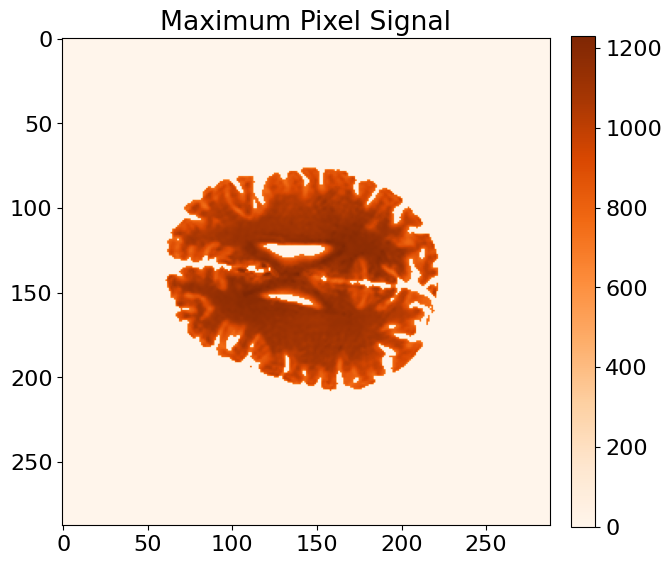

In [128]:
fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(7,9))
imc1 = ax.imshow(np.max(I_data[:, :, :], axis = -1), cmap = 'Oranges', vmin = 0)
ax.set_title("Maximum Pixel Signal")
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.show()

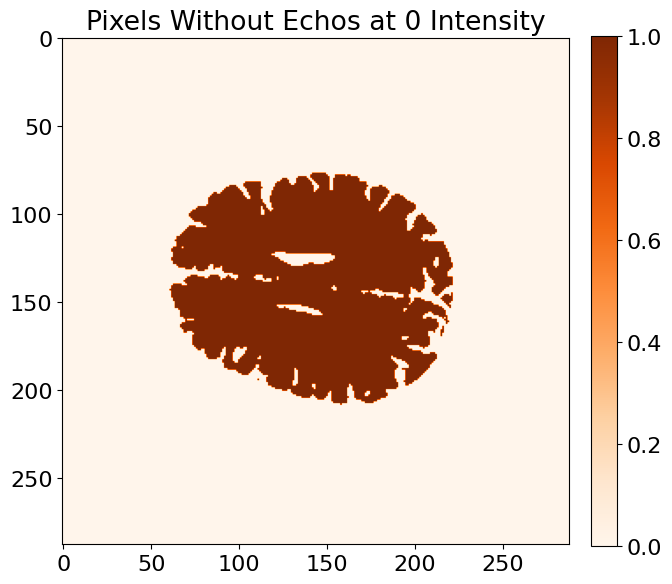

In [125]:
fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(7,9))
imc1 = ax.imshow(np.min(I_data[:, :, :], axis = -1)!=0, cmap = 'Oranges', vmin = 0)
ax.set_title("Pixels Without Echos at 0 Intensity")
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.show()

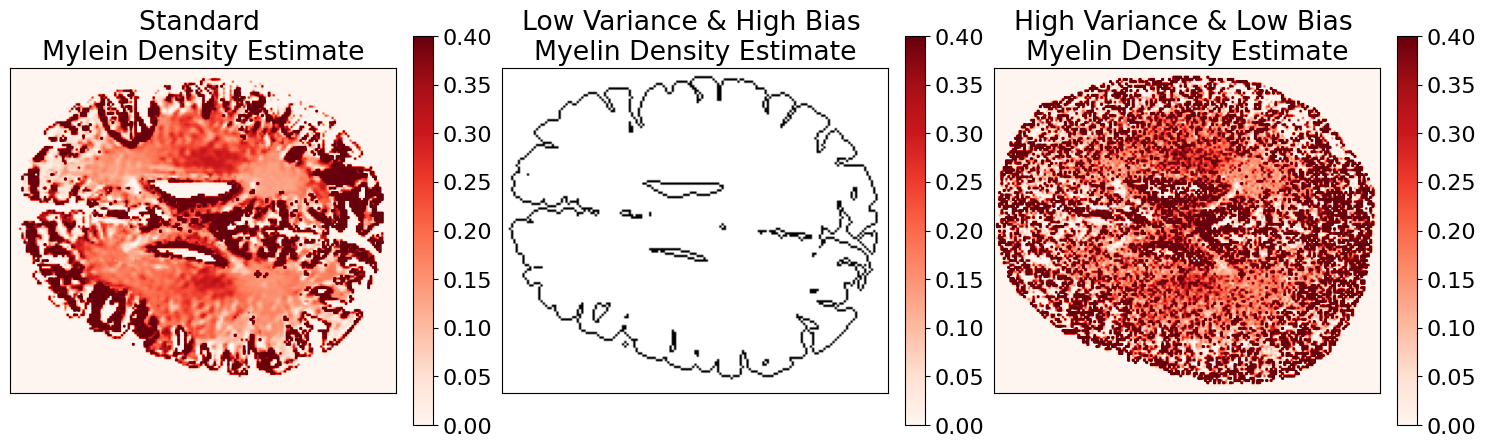

In [126]:
fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
# fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

v_hi = n_vert//4*3
v_lo = n_vert//4

h_hi = n_hori//5*4
h_lo = n_hori//5

plt.rc('font', size = 16)

imc1 = ax[0].imshow(NLLS_estimates_pn[v_lo:v_hi, h_lo:h_hi, 0], cmap = 'Reds', vmin=0, vmax = 0.4)
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title("Standard \nMylein Density Estimate")
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

imc2 = ax[1].imshow(1-high_bias_estimates[v_lo:v_hi, h_lo:h_hi], cmap = 'gray', vmin=0, vmax = 1)
fig.colorbar(imc1, ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_title("Low Variance & High Bias \nMyelin Density Estimate")
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
# fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04)

imc3 = ax[2].imshow(high_var_estimates_pn[v_lo:v_hi, h_lo:h_hi,0], cmap = 'Reds', vmin=0, vmax = 0.4)
fig.colorbar(imc3, ax=ax[2], fraction=0.046, pad=0.04)
ax[2].set_title("High Variance & Low Bias \nMyelin Density Estimate")
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

plt.show()

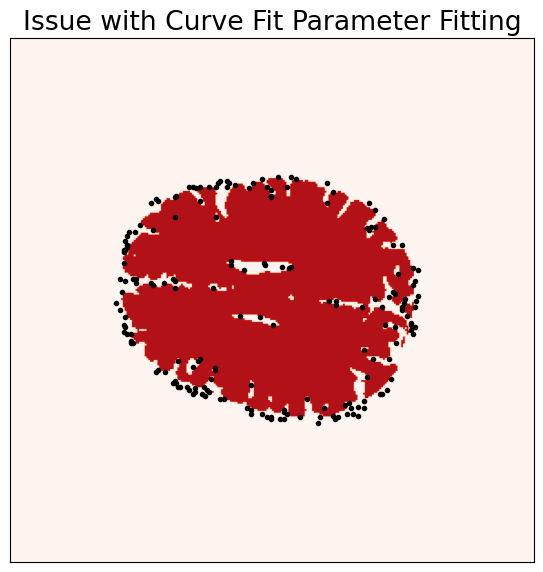

In [127]:
fig, ax = plt.subplots(1,1,figsize=(8,6), tight_layout=True)
# fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

array_fits = np.zeros((len(max_fits),2))
for i in range(len(max_fits)):
    array_fits[i,0] = max_fits[i][0]
    array_fits[i,1] = max_fits[i][1]

plt.rc('font', size = 16)

imc1 = ax.imshow(NLLS_estimates_pn[:,:, 0]>0, cmap = 'Reds', vmin=0, vmax = 1.2)
ax.plot(array_fits[:,1],array_fits[:,0], marker = 'o', ls = '', color = 'k', markersize = 3)
# fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)
ax.set_title("Issue with Curve Fit Parameter Fitting")
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)